# Fundamentals of Software Systems: Software Evolution, Part I - Assignment

**Nico Camillo Zala (18-753-202)**  
**Philippe Thomas Schmidli (17-742-305)**  
**Justin Simon Hehli (16-163-818)**


## Task 1: Codebase Overview
In this task, all commits between release 3.5.1 and 3.6.0 were considered.
For each entity, the number of revisions, the authors and the number of lines changed by each author are listed and saved in a JSON file.

In [ ]:
import json
from pydriller import Repository

# Define the path to the Apache Kafka repository
repository_path = './kafka'

# Define the target releases
start_tag = '3.5.1'
end_tag = '3.6.0'

# Create a dictionary to store entity information
entity_info = {}

# Iterate through the repository commits between two releases
for commit in Repository(repository_path, from_tag=start_tag, to_tag=end_tag, include_refs=True).traverse_commits():
    for modified_file in commit.modified_files:
        file_path = modified_file.new_path
        
        # Ignore files that no longer exist
        if file_path is None:
            continue
            
        # Create an entry for the entity if it doesn't exist in the dictionary
        if file_path not in entity_info:
            entity_info[file_path] = {
                'num of revisions': 0,
                'authors': {},
                'revisions': {},
            }

        # Update number of revisions
        entity_info[file_path]['num of revisions'] += 1
        
        # Create an entry for the author if it doesn't exist in the dictionary
        author_name = commit.author.name
        if author_name not in entity_info[file_path]['authors']:
            entity_info[file_path]['authors'][author_name] = {
                'added': 0,
                'removed': 0,
                'total': 0,
            }
            
        # Update author information
        entity_info[file_path]['authors'][author_name]['added'] += modified_file.added_lines
        entity_info[file_path]['authors'][author_name]['removed'] += modified_file.deleted_lines
        entity_info[file_path]['authors'][author_name]['total'] += modified_file.added_lines + modified_file.deleted_lines
        entity_info[file_path]['revisions'][commit.hash] = {
            'changed lines': modified_file.added_lines + modified_file.deleted_lines
        }

# Save the results to a JSON file
with open('entity_info.json', 'w') as json_file:
    json.dump(entity_info, json_file, indent=2)
    

The following code is used to read the generated JSON file and display it here.

In [4]:
# Open the JSON-File and print the data
with open('entity_info.json', 'r') as file:
    data = json.load(file)
print(json.dumps(data, indent=2))

{
  "gradle.properties": {
    "num of revisions": 2,
    "authors": {
      "Divij Vaidya": {
        "added": 2,
        "removed": 2,
        "total": 4
      }
    },
    "revisions": {
      "2c6fb6c54472e90ae17439e62540ef3cb0426fe3": {
        "changed lines": 2
      },
      "9f9cfbd6fabfb50cd4e9dacb4e8b9d88265f91e6": {
        "changed lines": 2
      }
    }
  },
  "streams\\quickstart\\java\\pom.xml": {
    "num of revisions": 2,
    "authors": {
      "Divij Vaidya": {
        "added": 2,
        "removed": 2,
        "total": 4
      }
    },
    "revisions": {
      "2c6fb6c54472e90ae17439e62540ef3cb0426fe3": {
        "changed lines": 2
      },
      "9f9cfbd6fabfb50cd4e9dacb4e8b9d88265f91e6": {
        "changed lines": 2
      }
    }
  },
  "streams\\quickstart\\java\\src\\main\\resources\\archetype-resources\\pom.xml": {
    "num of revisions": 2,
    "authors": {
      "Divij Vaidya": {
        "added": 2,
        "removed": 2,
        "total": 4
      }
    },
    

## Task 2: Complexity hotspots

### Step 1: Collect a list of all Java files for release 3.6.0

To checkout the last major release 3.6.0, the below git commands were used. It was assumed that the release 3.6.0 corresponds to the tag 3.6.0 and branch 3.6. The repo was cloned locally to improve performance.

1. git clone https://github.com/apache/kafka.git
2. git checkout tags/3.6.0 -b 3.6

Two "helper" functions *df_to_csv* and *csv_to_df* were defined to write / read a pandas dataframe to / from a CSV file. These will be used later throughout the subtasks, to store and retrieve data from a local CSV file. This enables storing intermediate results and executing steps based on those.

The java files are collected using glob

In [2]:
from pydriller import Repository, Git

In [2]:
# Create a list (pandas dataframe) of all .java files
import glob
import pandas as pd


def df_to_csv(df):
    df.to_csv('java_files.csv', index=False)


def csv_to_df():
    return pd.read_csv('java_files.csv')


java_files = []
for filename in glob.glob('./kafka/**/*.java', recursive=True):
    java_files.append(filename)

df = pd.DataFrame()
df['filename'] = java_files
df_to_csv(df)

pd.set_option('display.max_colwidth', None)
df.head()

filename
0      ./kafka\clients\src\main\java\org\apache\kafka\clients\ApiVersions.java
1  ./kafka\clients\src\main\java\org\apache\kafka\clients\ClientDnsLookup.java
2    ./kafka\clients\src\main\java\org\apache\kafka\clients\ClientRequest.java
3   ./kafka\clients\src\main\java\org\apache\kafka\clients\ClientResponse.java
4      ./kafka\clients\src\main\java\org\apache\kafka\clients\ClientUtils.java

### Step 2: Measure the complexity of all collected Java files using all four metrics

To measure the cyclomatic complexity (CC) and lines of code (LOC), the _lizard_ python package was used. Lizard enables measuring these complexities on a file directly, which simplified the task (simply iterate over files and call lizard functions())) compared to pydriller, which is very commit-centered. For some files, calculating these complexities resulted in an exception, which is why it was wrapped in a try/except block. If en error occurs during complexity computation, the complexity for a file is set to 0 (instead of None to simplify ordering etc. later, since we're only interested in high complexity values for our analysis)


In [4]:
# calculate CC / LOC for each file using lizard
import lizard

df = csv_to_df()
cc_list = []
loc_list = []
for i in df.index:
    cc = 0
    nloc = 0
    try:
        i = lizard.analyze_file(df.iloc[i]['filename'])
        nloc = i.function_list[0].__dict__['nloc']
        cc = i.function_list[0].__dict__['cyclomatic_complexity']
    except:
        pass
    cc_list.append(cc)
    loc_list.append(nloc)

df['cc'] = cc_list
df['loc'] = loc_list
df_to_csv(df)

The number of code changes (NCC) has already been for all changes between version 3.5.1 and 3.6.0 in Task 1. The resulting JSON file was used to extract this information for Task 2. Since not every Java file was necessarily changed in this timeframe, the NCC complexity is set to 0 if no record for a file could be found in the JSON file.

In [5]:
# set the NCC based on entity_info.json from task 1
import json

entity_info = {}
with open('./entity_info.json') as json_file:
    entity_info = json.load(json_file)

df = csv_to_df()
df['ncc'] = 0
for i in df.index:
    filename_ef = df.iloc[i]['filename'][len("./kafka\\\\"):]
    try:
        df.at[i, 'ncc'] = entity_info[filename_ef]["num of revisions"]
    except:
        df.at[i, 'ncc'] = 0

df_to_csv(df)

The indentation based complexity (IC) was calculated by traversing over each file's lines, and summing up the whitespace "blocks" at the start of a line. A block was defined as 4 spaces.

In [6]:
# calculate the IC
df = csv_to_df()
df['ic'] = 0
for i in df.index:
    ic = 0
    with open(df.iloc[i]['filename'], encoding="utf8") as f:
        for line in f:
            leading_spaces = len(line) - len(line.lstrip(' '))
            ic = ic + (leading_spaces / 4) if leading_spaces >= 4 else ic
        df.at[i, 'ic'] = ic

df_to_csv(df)

C:\Users\juhe9\AppData\Local\Temp\ipykernel_7164\3666256142.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '166.75' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.at[i, 'ic'] = ic


### Step 3: Visualize Hotspots

To visualize the hotspots, a heatmap is used. Since the list of all Java files has 4000+ entries, visualizing this whole list cannot be done while still being able to make sense of the resulting visualization. Thus, a collection consisting top 20 (highest complexity) entries per complexity (CC, LOC, NCC, IC) was computed from the original data set. Because the value ranges differ widely between the four complexity properties, they were first all scaled to a range of [0, 1], as to enable comparison between complexity categories. The resulting visualization is a heatmap with a white to dark-red color gradient, where files with the highest complexities can easily be identified by dark-red cell color.

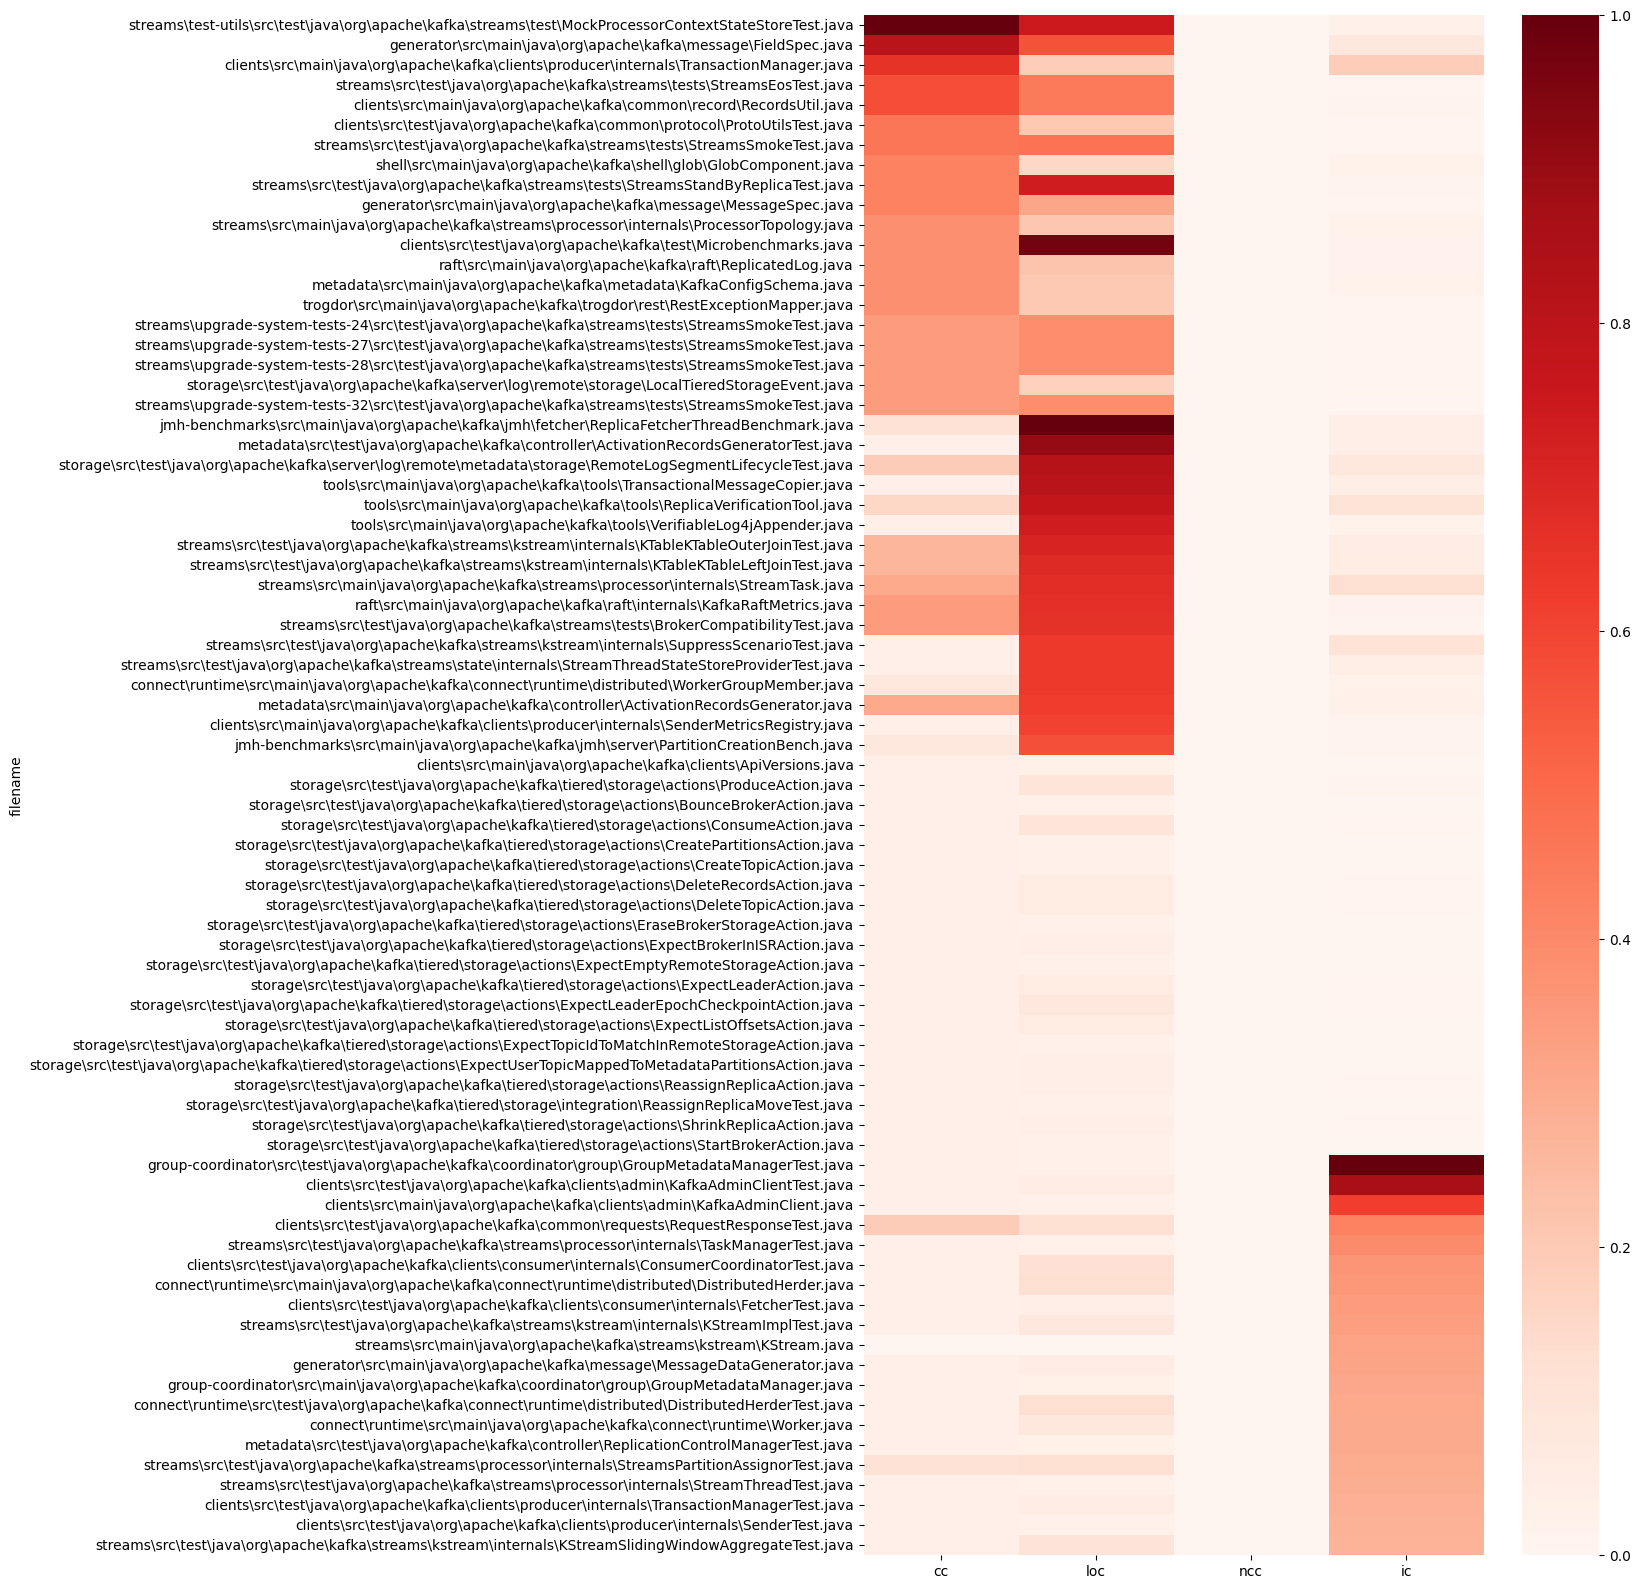

In [7]:
# create heatmap
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

top_metrics_df = csv_to_df()

mms = MinMaxScaler()
top_metrics_df[['cc', 'loc', 'ncc', 'ic']] = mms.fit_transform(
    top_metrics_df[['cc', 'loc', 'ncc', 'ic']])

top_metrics_df = pd.concat([
    top_metrics_df.sort_values('cc', ascending=False).head(20),
    top_metrics_df.sort_values('loc', ascending=False).head(20),
    top_metrics_df.sort_values('ncc', ascending=False).head(20),
    top_metrics_df.sort_values('ic', ascending=False).head(20),
])
top_metrics_df = top_metrics_df.drop_duplicates()

top_metrics_df['filename'] = top_metrics_df['filename'].str.replace(
    './kafka\\', '')
top_metrics_df = top_metrics_df.set_index('filename', drop=False)

fig, ax = plt.subplots(figsize=(10, 20))
sns.heatmap(top_metrics_df[['cc', 'loc', 'ncc', 'ic']],
            cmap="Reds", xticklabels=True, yticklabels=True)
plt.show()

### Step 4: Complexity Trend Analysis

We manually selected 10 hotspots based on the above heatmap, which are files with dark-red cells in one of the complexity measures, meaning they have a high complexity in at least one measure.

To analyse the complexity change over time for these files, all commits of each of them were traversed, and the commit date plus cyclomatic complexity of the correspondig (modified) file in the commit were extracted from those commits. This data was the plotted in a line chart, with one line per file. A line thus shows the progression of a file's CC over time, with each data point per line corresponding to a commit.

For some files, the complexity stayed relatively constant, for others there is a clear upwards trend. We'd argue that those with the upwards trend are more critical and likely to be hotspots, since their complexity kept increasing and might increase further in the future.

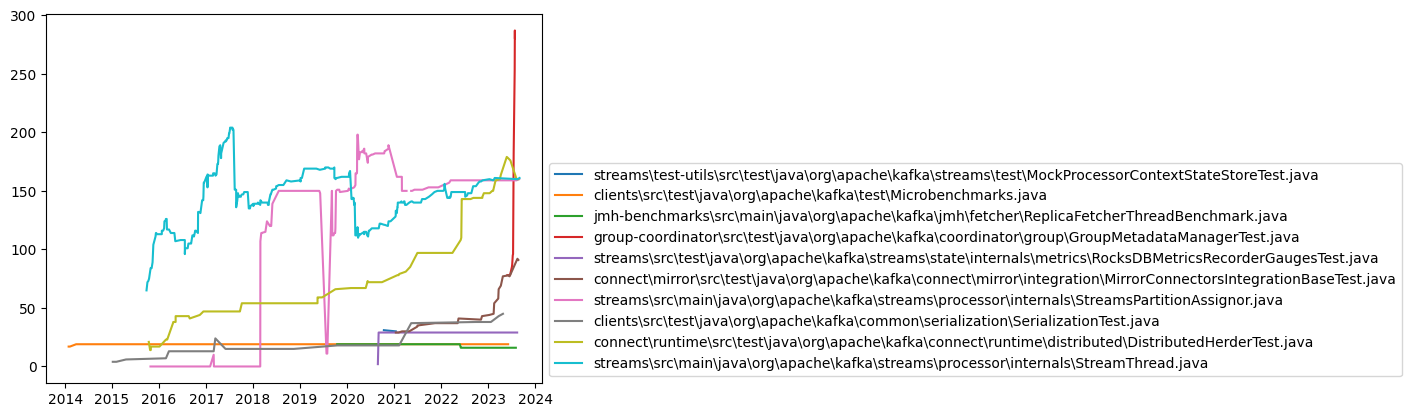

In [15]:
# in-depth complexity analysis on ten files
hotspots = [
    "streams\\test-utils\\src\\test\\java\\org\\apache\\kafka\\streams\\test\\MockProcessorContextStateStoreTest.java",
    "clients\\src\\test\\java\\org\\apache\\kafka\\test\\Microbenchmarks.java",
    "jmh-benchmarks\\src\\main\\java\\org\\apache\\kafka\\jmh\\fetcher\\ReplicaFetcherThreadBenchmark.java",
    "group-coordinator\\src\\test\\java\\org\\apache\\kafka\\coordinator\\group\\GroupMetadataManagerTest.java",
    "streams\\src\\test\\java\\org\\apache\\kafka\\streams\\state\\internals\\metrics\\RocksDBMetricsRecorderGaugesTest.java",
    "connect\\mirror\\src\\test\\java\\org\\apache\\kafka\\connect\\mirror\\integration\\MirrorConnectorsIntegrationBaseTest.java",
    "streams\\src\\main\\java\\org\\apache\\kafka\\streams\\processor\\internals\\StreamsPartitionAssignor.java",
    "clients\\src\\test\\java\\org\\apache\\kafka\\common\\serialization\\SerializationTest.java",
    "connect\\runtime\\src\\test\\java\\org\\apache\\kafka\\connect\\runtime\\distributed\\DistributedHerderTest.java",
    "streams\\src\\main\\java\\org\\apache\\kafka\\streams\\processor\\internals\\StreamThread.java",
]

X = []
Y = []
for h in hotspots:
    x = []
    y = []
    for c in Repository('./kafka/', filepath=h).traverse_commits():
        modified_file = next(
            filter(lambda f: h.endswith(f.filename), c.modified_files), None)
        x.append(c.committer_date)
        y.append(modified_file.complexity if modified_file is not None else 0)
    X.append(x)
    Y.append(y)
    plt.plot(x, y, label=h)
plt.legend(bbox_to_anchor=(1, 0), loc="lower left")
plt.show()

## Task 3: Temporal and Logical Coupling


In [12]:
# relevant imports
from pydriller import Repository
from datetime import datetime, timedelta
import itertools
import json
import pandas as pd
from tqdm import tqdm
import numpy as np
from itertools import combinations, product
from collections import defaultdict

In [13]:
# Apache Kafka repo
path = "./kafka"

### Temporal Coupling

In [14]:
# Get all commits from repository
commits = Repository(path).traverse_commits()

In [5]:
files = set()

for commit in tqdm(commits, desc="Processing Commits", unit="commit"):
    modified_files = set([m.filename for m in commit.modified_files])
    files.update(modified_files)

Processing Commits: 11903commit [02:26, 81.32commit/s]


In [6]:
print(f"number of files: {len(files)}")

number of files: 7241


First create a commit Dataframe to look up commits with following columns:
- commit_id: int
- timestamp: date
- files: list of files

In [15]:
def create_commit_dataframe(path, commits):
    commit_dict = {}
    
    for commit in tqdm(commits, desc="Processing Commits", unit="commit"):
        commit_id = commit.hash
        commit_timestamp = commit.author_date
        modified_files = set([m.filename for m in commit.modified_files])

        commit_dict[commit_id] = {"timestamp": commit_timestamp,
                                  "files": modified_files}

    # Convert the dictionary to a DataFrame
    commit_df = pd.DataFrame.from_dict(commit_dict, orient='index').reset_index()
    commit_df.columns = ['commit_id', 'timestamp', 'files']

    return commit_df, commit_dict

commit_df, commit_dict = create_commit_dataframe(path, commits)

Processing Commits: 11903commit [02:28, 80.39commit/s] 


In [17]:
commit_df.head()

commit_id                  timestamp  \
0  642da2f28c9bc6e373603d6d9119ce33684090f5  2011-08-01 23:41:24+00:00   
1  cbbfbaf33179f2a44ae641ccaaba1f0a8e73730f  2011-08-03 17:34:03+00:00   
2  665f1d0527846e1eaf6c39fd8a329dbfeb08b0c9  2011-08-05 01:36:43+00:00   
3  96b8e03dd1ee23a550ca87803777b4d7bec05d5a  2011-08-07 16:29:55+00:00   
4  f7046c247dd466c90337bb39a4612115c3e41923  2011-08-07 23:56:05+00:00   

                                               files  
0  {Pool.scala, encoder_helper_tests.cpp, MultiFe...  
1                                       {.gitignore}  
2                            {zkclient-20110412.jar}  
3  {ZKEphemeralTest.scala, ZookeeperConsumerConne...  
4                               {ProducerPool.scala}

Next loop through all commits, and check which other commits in the curren time_window searching the commit-dataframe.  
Adding/updating all file combinations of temporal coupled commits in dictionary.

In [18]:
TIME_WINDOWS = [24, 48, 72, 168]

In [20]:
def temporal_coupling(path, commit_df, commit_dict, time_windows, files):

    result_dict = {}
    commits = Repository(path).traverse_commits()


    for commit in tqdm(commit_dict, desc="Processing Commits", unit="commit"):

        commit_timestamp = commit_dict[commit]["timestamp"]
        modified_files = commit_dict[commit]["files"]
        modified_files = files & modified_files

        for time_window in time_windows:
            
            time_window_end = commit_timestamp + timedelta(hours=time_window)

            mask = True
            mask &= commit_df["timestamp"] >= commit_timestamp
            mask &= commit_df["timestamp"] <= time_window_end

            filtered_df = commit_df[mask]

            commits_in_window = set(commit_df["commit_id"].unique())
                
            modified_files_in_window = set(filtered_df['files'].explode().unique())
            modified_files_in_window = files & modified_files_in_window

            result_dict = add_coupled_files_to_dict(result_dict, modified_files, modified_files_in_window, time_window, files)

    return result_dict

def add_coupled_files_to_dict(dictionary, file_set_1, file_set_2, time_window, files):

    file_combinations = [(file1, file2) for file1, file2 in product(file_set_1, file_set_2) if file1 != file2]

    for file1, file2 in file_combinations:
        combination = sorted([file1, file2])
        key = f"{combination[0]} - {combination[1]}"

        if key not in dictionary:
            dictionary[key] = {
                "files": [file1, file2],
                "time_windows": {24: 0, 48: 0, 72: 0, 168: 0}
            }

        dictionary[key]["time_windows"][time_window] = dictionary[key]["time_windows"].get(time_window, 0) + 1
   
    return dictionary


In [21]:
temporal_coupling_result = temporal_coupling(path, commit_df, commit_dict, TIME_WINDOWS, files)

Processing Commits: 100%|█████████████| 11903/11903 [23:02<00:00,  8.61commit/s]


In [28]:
def store_temporal_coupling_to_json(dictionary, file_name):

    result_list = []

    for key in tqdm(dictionary, desc="Processing Coupled Files", unit="file-pair"):

        file_pair = dictionary[key]["files"]
        joint_commits_24 = dictionary[key]["time_windows"][24]
        joint_commits_48 = dictionary[key]["time_windows"][48]
        joint_commits_72 = dictionary[key]["time_windows"][72]
        joint_commits_168 = dictionary[key]["time_windows"][168]


        # Create a dictionary for the current pair
        current_dict = {
            "file_pair": file_pair,
            "coupled_commits": [
                {
                    "time_window": 24,
                    "commit_count": joint_commits_24
                },
                {
                    "time_window": 48,
                    "commit_count": joint_commits_48
                },
                {
                    "time_window": 72,
                    "commit_count": joint_commits_72
                },
                {
                    "time_window": 168,
                    "commit_count": joint_commits_168
                },
            ]
        }

        # Append the dictionary to the result list
        result_list.append(current_dict)

    # Save the list of dictionaries to a JSON file
    with open(file_name, 'w') as json_file:
        json.dump(result_list, json_file, indent=2)

In [29]:
store_temporal_coupling_to_json(temporal_coupling_result, "temporal_coupling.JSON")

Processing Coupled Files: 100%|█| 4705414/4705414 [00:18<00:00, 252753.67file-pa


In [26]:
def find_top_entries_with_largest_temporal_coupling(comb_dict, time_window, top_n):
    top_entries = sorted(comb_dict.items(), key=lambda x: x[1]["time_windows"][time_window], reverse=True)[:top_n]
    
    return top_entries


10 Strongest temporal coupled files in 24 h window:

In [27]:
find_top_entries_with_largest_temporal_coupling(temporal_coupling_result, 24, 10)

[('KafkaApis.scala - ReplicaManager.scala',
  {'files': ['KafkaApis.scala', 'ReplicaManager.scala'],
   'time_windows': {24: 397, 48: 483, 72: 521, 168: 675}}),
 ('StreamThread.java - StreamThreadTest.java',
  {'files': ['StreamThread.java', 'StreamThreadTest.java'],
   'time_windows': {24: 370, 48: 388, 72: 402, 168: 448}}),
 ('KafkaApis.scala - RequestResponseTest.java',
  {'files': ['KafkaApis.scala', 'RequestResponseTest.java'],
   'time_windows': {24: 369, 48: 411, 72: 433, 168: 508}}),
 ('Partition.scala - ReplicaManager.scala',
  {'files': ['Partition.scala', 'ReplicaManager.scala'],
   'time_windows': {24: 353, 48: 375, 72: 393, 168: 439}}),
 ('KafkaApis.scala - TestUtils.scala',
  {'files': ['TestUtils.scala', 'KafkaApis.scala'],
   'time_windows': {24: 347, 48: 420, 72: 473, 168: 641}}),
 ('Log.scala - LogTest.scala',
  {'files': ['LogTest.scala', 'Log.scala'],
   'time_windows': {24: 341, 48: 357, 72: 370, 168: 410}}),
 ('KafkaApis.scala - KafkaServer.scala',
  {'files': ['K

10 Strongest temporal coupled files in 48 h window:

In [23]:
find_top_entries_with_largest_temporal_coupling(temporal_coupling_result, 48, 10)

[('KafkaApis.scala - ReplicaManager.scala',
  {'files': ['KafkaApis.scala', 'ReplicaManager.scala'],
   'time_windows': {24: 397, 48: 483, 72: 521, 168: 675}}),
 ('KafkaApis.scala - TestUtils.scala',
  {'files': ['TestUtils.scala', 'KafkaApis.scala'],
   'time_windows': {24: 347, 48: 420, 72: 473, 168: 641}}),
 ('KafkaApis.scala - RequestResponseTest.java',
  {'files': ['KafkaApis.scala', 'RequestResponseTest.java'],
   'time_windows': {24: 369, 48: 411, 72: 433, 168: 508}}),
 ('KafkaApis.scala - KafkaServer.scala',
  {'files': ['KafkaServer.scala', 'KafkaApis.scala'],
   'time_windows': {24: 332, 48: 396, 72: 433, 168: 573}}),
 ('StreamThread.java - StreamThreadTest.java',
  {'files': ['StreamThread.java', 'StreamThreadTest.java'],
   'time_windows': {24: 370, 48: 388, 72: 402, 168: 448}}),
 ('build.gradle - dependencies.gradle',
  {'files': ['build.gradle', 'dependencies.gradle'],
   'time_windows': {24: 330, 48: 379, 72: 409, 168: 529}}),
 ('Partition.scala - ReplicaManager.scala',


10 Strongest temporal coupled files in 72 h window:

In [24]:
find_top_entries_with_largest_temporal_coupling(temporal_coupling_result, 72, 10)

[('KafkaApis.scala - ReplicaManager.scala',
  {'files': ['KafkaApis.scala', 'ReplicaManager.scala'],
   'time_windows': {24: 397, 48: 483, 72: 521, 168: 675}}),
 ('KafkaApis.scala - TestUtils.scala',
  {'files': ['TestUtils.scala', 'KafkaApis.scala'],
   'time_windows': {24: 347, 48: 420, 72: 473, 168: 641}}),
 ('KafkaApis.scala - KafkaServer.scala',
  {'files': ['KafkaServer.scala', 'KafkaApis.scala'],
   'time_windows': {24: 332, 48: 396, 72: 433, 168: 573}}),
 ('KafkaApis.scala - RequestResponseTest.java',
  {'files': ['KafkaApis.scala', 'RequestResponseTest.java'],
   'time_windows': {24: 369, 48: 411, 72: 433, 168: 508}}),
 ('KafkaApis.scala - build.gradle',
  {'files': ['KafkaApis.scala', 'build.gradle'],
   'time_windows': {24: 233, 48: 344, 72: 427, 168: 672}}),
 ('KafkaApis.scala - KafkaConfig.scala',
  {'files': ['KafkaConfig.scala', 'KafkaApis.scala'],
   'time_windows': {24: 282, 48: 363, 72: 418, 168: 589}}),
 ('build.gradle - dependencies.gradle',
  {'files': ['build.grad

10 Strongest temporal coupled files in 168 h window:

In [25]:
find_top_entries_with_largest_temporal_coupling(temporal_coupling_result, 168, 10)

[('KafkaApis.scala - ReplicaManager.scala',
  {'files': ['KafkaApis.scala', 'ReplicaManager.scala'],
   'time_windows': {24: 397, 48: 483, 72: 521, 168: 675}}),
 ('KafkaApis.scala - build.gradle',
  {'files': ['KafkaApis.scala', 'build.gradle'],
   'time_windows': {24: 233, 48: 344, 72: 427, 168: 672}}),
 ('KafkaApis.scala - TestUtils.scala',
  {'files': ['TestUtils.scala', 'KafkaApis.scala'],
   'time_windows': {24: 347, 48: 420, 72: 473, 168: 641}}),
 ('KafkaApis.scala - KafkaConfig.scala',
  {'files': ['KafkaConfig.scala', 'KafkaApis.scala'],
   'time_windows': {24: 282, 48: 363, 72: 418, 168: 589}}),
 ('KafkaApis.scala - KafkaServer.scala',
  {'files': ['KafkaServer.scala', 'KafkaApis.scala'],
   'time_windows': {24: 332, 48: 396, 72: 433, 168: 573}}),
 ('KafkaApis.scala - Log.scala',
  {'files': ['Log.scala', 'KafkaApis.scala'],
   'time_windows': {24: 281, 48: 342, 72: 394, 168: 543}}),
 ('build.gradle - dependencies.gradle',
  {'files': ['build.gradle', 'dependencies.gradle'],
 

### Logical Coupling

The function logical_coupling is the main function which computes the Logical-Coupling between all files in the repository.  
Store_coupled_files_to_dict and store_file_to_dict are just helper functions to store the data.  

In [7]:
def logical_coupling(url_repo):

    combination_dict = {}
    individual_dict = {}

    commits = Repository(url_repo).traverse_commits()
    
    for commit in tqdm(commits, desc="Processing Commits", unit="commit"):

        modified_files = set([m.filename for m in commit.modified_files])

        if len(modified_files) < 2: #no coupled files in commit
            continue
        
        file_combinations = list(itertools.combinations(modified_files, 2))

        for combination in file_combinations:

            combination_dict = store_coupled_files_in_dict(combination_dict, combination)
            
        individual_dict = store_file_in_dict(individual_dict, modified_files)
            
        #print("-"*20)

    return combination_dict, individual_dict

def store_coupled_files_in_dict(dictionary, combination):
    
    combination = sorted(combination)
    key = combination[0] + " - " + combination[1]

    if key not in dictionary:
        dictionary[key] = 1
        dictionary[key] = {
                        "files": combination,
                        "joint_commits": 1
                    }
        
    else:
        dictionary[key]["joint_commits"]+= 1

    return dictionary

def store_file_in_dict(dictionary, files):

    for file in files:

        if file not in dictionary:
            dictionary[file] = 1

        else:
            dictionary[file]+= 1

    return dictionary

In [8]:
def store_logical_coupling_to_json(comb_dict, ind_dict, file_name):

    result_list = []

    # Create a tqdm progress bar for the loop
    for key in tqdm(comb_dict, desc="Writing to JSON", unit=" pair"):

        file_pair = comb_dict[key]["files"]
        joint_commits = comb_dict[key]["joint_commits"]

        file1_commits = ind_dict[file_pair[0]] - joint_commits
        file2_commits = ind_dict[file_pair[1]] - joint_commits

        # Create a dictionary for the current pair
        current_dict = {
            "file_pair": file_pair,
            "logical_coupling": {
                "Joint": joint_commits,
                file_pair[0]: file1_commits,
                file_pair[1]: file2_commits
            }
        }

        # Append the dictionary to the result list
        result_list.append(current_dict)

    # Save the list of dictionaries to a JSON file
    with open(file_name, 'w') as json_file:
        json.dump(result_list, json_file, indent=2)

Compute Logical Coupling over entire Repository

In [9]:
comb_files_result, ind_files_result = logical_coupling(path)

Processing Commits: 11903commit [02:37, 75.81commit/s]


Store Logical Coupling result to JSON file.

In [11]:
store_logical_coupling_to_json(comb_files_result, ind_files_result, "logical_coupling.JSON")

Writing to JSON: 100%|█████████| 1258215/1258215 [00:03<00:00, 404415.55 pair/s]


Find the top 10 files which are tightest logical coupled

In [14]:
def find_top_entries_with_largest_joint_commits(comb_dict, top_n=3):
    top_entries = sorted(comb_dict.items(), key=lambda x: x[1]["joint_commits"], reverse=True)[:top_n]
    
    return top_entries

In [15]:
find_top_entries_with_largest_joint_commits(comb_files_result, 10)

[('StreamThread.java - StreamThreadTest.java',
  {'files': ['StreamThread.java', 'StreamThreadTest.java'],
   'joint_commits': 170}),
 ('Log.scala - LogTest.scala',
  {'files': ['Log.scala', 'LogTest.scala'], 'joint_commits': 159}),
 ('Partition.scala - ReplicaManager.scala',
  {'files': ['Partition.scala', 'ReplicaManager.scala'],
   'joint_commits': 159}),
 ('KafkaApis.scala - RequestResponseTest.java',
  {'files': ['KafkaApis.scala', 'RequestResponseTest.java'],
   'joint_commits': 156}),
 ('KafkaApis.scala - ReplicaManager.scala',
  {'files': ['KafkaApis.scala', 'ReplicaManager.scala'],
   'joint_commits': 148}),
 ('KafkaApis.scala - KafkaApisTest.scala',
  {'files': ['KafkaApis.scala', 'KafkaApisTest.scala'], 'joint_commits': 146}),
 ('ReplicaManager.scala - ReplicaManagerTest.scala',
  {'files': ['ReplicaManager.scala', 'ReplicaManagerTest.scala'],
   'joint_commits': 141}),
 ('StreamTask.java - StreamTaskTest.java',
  {'files': ['StreamTask.java', 'StreamTaskTest.java'], 'joint_

#### In-depth analysis of 3 sets of strongly coupled files

We look at 3 sets of files, which are strongly coupled by **logical coupling**:

##### 1. `StreamThread.java` and `StreamThreadTest.java`

With 170 joint commits StreamThread.java and StreamThreadTest.java are strongest coupled files from the whole Kafka repository.
It is reasonable that when modifications in the class of StreamThread.java are made, that also the tests need to adjusted accordingly in the StreamThreadTest.java . It makes sense, that there is always a coupling between a file and it's corresponding test-file, they go often hand-in-hand. --> Unit-Test-Relationship

##### 2. `Partition.scala`and `ReplicaManager.scala`

Tese two files have 159 joint commits and also strongly logical coupled.  
The files have an architectural dependency. Meaning that ReplicaManager is responsible for managing the state of partitions. 
To manage the states of partitions, ReplicaManager.scala is dependend on Partition.scala, which means modifications in Partition.scala often lead to modifications in ReplicaManager.scala.

##### 3. `KafkaApis.scala`and `ReplicaManager.scala`

These two filese have 148 joint commits. These files have also an architectural dependency.  
Meaning KafkaApi.scala seem to strongly depend on ReplicaManager.scala, resulting that modifications in ReplicaManager.scale enforce also changes in KafkaApis.scala.